In [1]:
import pandas as pd
import pickle
def save(data , fn):
    with open(fn, 'wb') as f:
        pickle.dump(data, f)
def load(fn): 
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

In [2]:
days = []
prices = []

In [3]:
TRADE3 = load("./TRADE_201903.obj")
for i in TRADE3.keys():     
    days.append(i)
    prices.append(TRADE3[i]["Price"].iloc[-1])

In [4]:
TRADE4 = load("./TRADE_201904.obj")
for i in TRADE4.keys():     
    days.append(i)
    prices.append(TRADE4[i]["Price"].iloc[-1])

In [5]:
TRADE5 = load("./TRADE_201905.obj")
for i in TRADE5.keys():     
    days.append(i)
    prices.append(TRADE5[i]["Price"].iloc[-1])

In [6]:
TRADE6 = load("./TRADE_201906.obj")
for i in TRADE6.keys():     
    days.append(i)
    prices.append(TRADE6[i]["Price"].iloc[-1])

In [7]:
import math
import datetime
from datetime import datetime
import numpy as np
from scipy.stats import norm

class EuropeanCall:

    def call_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1
    
    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration           
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)   
        
class EuropeanPut:

    def put_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1 - 1
    
    def put_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log((b*strike_price)/asset_price) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = b*strike_price*z1
        x2 = math.log((b*strike_price)/asset_price) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = asset_price*z2
        return z1 - z2
    
    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.put_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.put_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [8]:
from datetime import datetime
days_new = []
for i in days:
    time = f'{i[0:4]}-{i[4:6]}-{i[6:]}'
    date_time_obj = datetime.strptime(time, '%Y-%m-%d')
    days_new.append(date_time_obj)    

In [9]:
start_date = days_new[0]
ex = days_new[len(days)-1]
total = ex-start_date # จำนวนวันทั้งหมด ตั้งแต่วันแรกถึงวันคบกำหนด

In [10]:
vol = 0.2285808933847129

In [11]:
# short put option : strike price=130, r=6%
initial_sp = EuropeanPut(prices[0], vol, 130, total.days/365, 0.06)

In [12]:
time = []
for i in range(0,len(days_new)):
    date = days_new[i]
    t = ex-date
    if t.days==0 :
        time.append(1)
        continue
    time.append(t.days)

In [13]:
# hedge delta : delta ของการhedge แต่ละครั้ง
# sp_delta : delta ของ short put option แต่ละรอบ
# opt_price ราคา option ของแต่ละวัน
hedge_deltas = []
sp_deltas = []
opt_price = []
for i in range(0,len(days)):
    put = EuropeanPut(prices[i], initial_sp.asset_volatility, initial_sp.strike_price, time[i]/365, initial_sp.risk_free_rate)
    hedge_deltas.append(put.delta)    
    sp_deltas.append(-1*put.delta)
    opt_price.append(put.price)

In [14]:
contract = 10000 # มี option ทั้งหมด 10,000 สัญญา
share_per_contract = 100 # สัญญาละ 100 หุ้น
total_share = share_per_contract*contract
sp_option_price = initial_sp.price
premium = sp_option_price*total_share # ค่า premium = option price x จำนวนหุ้นทั้งหมด
start_price = prices[0]
DeltaxShare = round(total_share*sp_deltas[0]) # จำนวนหุ้นที่จะshort เพื่อhedgeในวันแรก
DeltaxShare = (DeltaxShare // 100) * 100
cumulative_cost = round(DeltaxShare*prices[0]) # เงินที่ได้จากการshortหุ้นเพื่อ hedge ในวันแรก

In [15]:
DeltaxShares = []
cumulative_costs = []
DeltaxShares.append(DeltaxShare)
cumulative_costs.append(cumulative_cost)
PandLs = []
PandLs.append(round(premium)) # profit and loss ของวันแรก เท่ากับ premium

In [16]:
# คำนวณ Delta x share, cumulative และ daily return ของแต่ละวัน
for i in range(1,len(days)):    
    DeltaxShare = round(total_share*sp_deltas[i])
    DeltaxShare = (DeltaxShare // 100) * 100
    d_share_held = DeltaxShare-DeltaxShares[i-1] # เช็คว่าปริมาณหุ้นที่เราจะshortเพื่อ hedge ของวันนี้ มากกว่าหรือน้อยกว่าปริมาณหุ้นเมื่อวาน
    if d_share_held < 0: # ถ้าผลต่างเป็นลบ แปลว่าเราจะซื้อหุ้นมาคืนบางส่วน
        if d_share_held <= -100: # เช็คว่าหุ้นที่จะซื้อมาคืน มีปริมาณมากกว่า100หรือไม่
            cost = prices[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ใช้ในการซื้อหุ้นคืน จะนำไปหักล้างกับค่า cumulative
        elif d_share_held > -100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการซื้อหุ้นมาคืน hedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas[i] = hedge_deltas[i-1]
    elif d_share_held > 0: # ถ้าผลต่างเป็นบวก แปลว่าเราจะshortหุ้นเพิ่ม
        if d_share_held > 100: # เช็คว่าหุ้นที่จะshort มีปริมาณมากกว่า100หรือไม่
            cost = prices[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ได้จากการshortหุ้น จะนำไปรวมกับ cumulative
        elif d_share_held < 100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการshort hedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas[i] = hedge_deltas[i-1]
    DeltaxShare = round(total_share*hedge_deltas[i]*-1)
    DeltaxShare = (DeltaxShare // 100) * 100
    DeltaxShares.append(DeltaxShare)
    cumulative_costs.append(round(cumulative_cost))
    d_opt_price = opt_price[i] - opt_price[i-1] # หาผลต่างของราคา option ของวันนี้กับวันที่ผ่านมา
    PandL = d_opt_price*total_share + cumulative_cost - DeltaxShare * prices[i] + premium
# p&l คิดจากผลต่างของราคา option คูณกับจำนวนหุ้นทั้งหมด + cumulative ที่สะสมมาทั้งหมด - ปริมาณหุ้นที่ต้องซื้อมาคืนคูณกับราคาของหุ้นอ้างอิง + premium
    PandLs.append(round(PandL))    

In [17]:
if prices[len(prices)-1] < initial_sp.strike_price - sp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดน้อยกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ OTM
    print("OTM")
    PandL = (-initial_sp.strike_price * total_share) + (total_share - DeltaxShares[len(DeltaxShares)-1]) * prices[len(prices)-1] + premium + cumulative_costs[len(cumulative_costs)-1]
#p&lคิดจาก -1*ราคาstrike priceคูณกับปริมาณหุ้นตามสัญญา + เงินที่ได้จากหุ้นที่เหลือ หลังนำหุ้นที่ได้จากสัญญาไปคืนให้ตามปริมาณที่shortมา +premium+cumulative ที่สะสมมาทั้งหมด
elif prices[len(prices)-1] >= initial_sp.strike_price - sp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดมากกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ ITM
    print("ITM")
    PandL = premium + cumulative_costs[len(cumulative_costs)-1]- (DeltaxShares[len(DeltaxShares)-1]*prices[len(prices)-1])
#p&lคิดจากpremium+cumulative ที่สะสมมาทั้งหมด                       ลบกับปริมาณหุ้นที่ต้องซื้อมาคืนคูณกับราคาของหุ้นอ้างอิงวันสุดท้าย
PandL1 = round(PandL)
print("profit and loss 1 =", PandL1)

ITM
profit and loss 1 = -29302


In [18]:
PandLs[len(PandLs)-1] = PandL1

In [19]:
import pandas as pd

# นำข้อมูลต่างๆ มาแสดงผลในรูปแบบ DataFrame
df_sp =  pd.DataFrame(
{"asset_price" : prices,
  "option price" : opt_price,
 "short put delta" : sp_deltas,
 "hedge delta" : hedge_deltas,
 "DeltaxShare" : DeltaxShares,
#  "funding interest" : funding_interests,
 "cumulative costs" : cumulative_costs,
 "profit and loss" : PandLs,
}, 
index = days_new)

In [20]:
df_sp

,asset_price,option price,short put delta,hedge delta,DeltaxShare,cumulative costs,profit and loss
2019-03-01,123.5000,8.712102,0.570585,-0.570585,570500,70456750,8712102
2019-03-04,122.3600,9.340923,0.601646,-0.601646,601600,74262146,9991293
2019-03-05,122.5000,9.244146,0.599345,-0.599345,599300,73980396,9181471
2019-03-06,121.5000,9.844072,0.625048,-0.625048,625000,77102946,10477474
2019-03-07,122.5000,9.218348,0.601635,-0.601635,601600,74236446,8626824
...,...,...,...,...,...,...,...
2019-06-24,136.0000,0.033982,0.027112,-0.027112,27100,-5053022,-214193
2019-06-25,135.5000,0.021924,0.020990,-0.020990,20900,-5893122,-25027
2019-06-26,134.0000,0.031042,0.034459,-0.034459,34400,-4084122,27498
2019-06-27,135.3895,0.000133,0.000319,-0.000319,300,-8700904,-60328


In [21]:
days2 = []
prices2 = []
hours = []
timestamps = []

In [22]:
first = 1
for i in TRADE3.keys():     
    for j in TRADE3[i]['Timestamp'].keys():
        now = TRADE3[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before = now
            continue
        if now == before:
            before = now
            price = TRADE3[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now)
        days2.append(i)
        timestamps.append(TRADE3[i]['Timestamp'][j])
        before = now

In [23]:
first = 1
for i in TRADE4.keys():     
    for j in TRADE4[i]['Timestamp'].keys():
        now4 = TRADE4[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before4 = now4
            continue
        if now4 == before4:
            before4 = now4
            price = TRADE4[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now4)
        days2.append(i)
        timestamps.append(TRADE4[i]['Timestamp'][j])
        before4 = now4

In [24]:
first = 1
for i in TRADE5.keys():     
    for j in TRADE5[i]['Timestamp'].keys():
        now5 = TRADE5[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before5 = now5
            continue
        if now5 == before5:
            before5 = now5
            price = TRADE5[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now5)
        days2.append(i)
        timestamps.append(TRADE5[i]['Timestamp'][j])
        before5 = now5

In [25]:
first = 1
for i in TRADE6.keys():     
    for j in TRADE6[i]['Timestamp'].keys():
        now6 = TRADE6[i]['Timestamp'][j].hour
        if first == 1:
            first = 0
            before6 = now6
            continue
        if now6 == before6:
            before6 = now6
            price = TRADE6[i]['Price'][j]
            continue
        prices2.append(price)
        hours.append(now6)
        days2.append(i)
        timestamps.append(TRADE6[i]['Timestamp'][j])
        before6 = now6

In [26]:
t0 = timestamps[0]
tfin = timestamps[len(timestamps)-1]
duration = tfin-t0
duration_in_s = duration.total_seconds() 
total_h = divmod(duration_in_s, 3600)[0] # จำนวนชั่วโมงทั้งหมด ตั้งแต่วันแรกถึงวันครบกำหนด

In [27]:
class EuropeanCall2:

    def call_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1
    
    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration           
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate) 
        
class EuropeanPut2:

    def put_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1 - 1
    
    def put_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log((b*strike_price)/asset_price) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = b*strike_price*z1
        x2 = math.log((b*strike_price)/asset_price) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = asset_price*z2
        return z1 - z2
    
    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.put_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.put_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [28]:
# short put option : strike price=130, r=6%, 8760คือจำนวนชั่วโมงทั้งหมดของ1ปี นำมาใช้แทน365ที่เป็นจำนวนวันทั้งหมด
initial_sp2 = EuropeanPut2(prices2[0], vol, 130, total_h/8760, 0.06)

In [29]:
t = []
for i in range(0,len(days2)):
    now = timestamps[i]
    duration = tfin - now
    duration_in_s = duration.total_seconds() 
    total_h = divmod(duration_in_s, 3600)[0]
    if total_h==0 :
        t.append(1)
        continue
    t.append(total_h)

In [30]:
# hedge delta 2 : delta ของการhedge แต่ละครั้ง
# sp_delta 2 : delta ของ short put option แต่ละรอบ
# opt_price2  ราคา option ของแต่ละชั่วโมง
hedge_deltas2 = []
sp_deltas2 = []
opt_price2 = []
for i in range(0,len(days2)):
    put = EuropeanPut2(prices2[i], initial_sp2.asset_volatility, initial_sp2.strike_price, t[i]/8760, initial_sp2.risk_free_rate)
    hedge_deltas2.append(put.delta)
    sp_deltas2.append(-1*put.delta)
    opt_price2.append(put.price)

In [31]:
total_share = share_per_contract*contract
sp_option_price = initial_sp2.price
premium = sp_option_price*total_share # ค่า premium = option price x จำนวนหุ้นทั้งหมด
start_price = prices2[0]
DeltaxShare = round(total_share*sp_deltas2[0]) # จำนวนหุ้นที่จะshort เพื่อhedgeในวันแรก
DeltaxShare = (DeltaxShare // 100) * 100
cumulative_cost = round(DeltaxShare*prices2[0]) # เงินที่ได้จากการshortหุ้นเพื่อ hedge ในวันแรก

In [32]:
DeltaxShares2 = []
cumulative_costs2 = []
DeltaxShares2.append(DeltaxShare)
cumulative_costs2.append(cumulative_cost)
PandLs2 = []
PandLs2.append(round(premium)) # profit and loss ของชั่วโมงแรก เท่ากับ premium

In [33]:
# คำนวณ Delta x share, cumulative และ daily return ของแต่ละชั่วโมง
for i in range(1,len(timestamps)):  
    DeltaxShare = round(total_share*sp_deltas2[i])
    DeltaxShare = (DeltaxShare // 100) * 100
    d_share_held = DeltaxShare-DeltaxShares2[i-1] # เช็คว่าปริมาณหุ้นที่เราจะshortเพื่อ hedge ของชั่วโมงนี้ มากกว่าหรือน้อยกว่าปริมาณหุ้นชั่วโมงก่อนหน้า
    if d_share_held < 0: # ถ้าผลต่างเป็นลบ แปลว่าเราจะซื้อหุ้นมาคืนบางส่วน
        if d_share_held <= -100: # เช็คว่าหุ้นที่จะซื้อมาคืน มีปริมาณมากกว่า100หรือไม่
            cost = prices2[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ใช้ในการซื้อหุ้นคืน จะนำไปหักล้างกับค่า cumulative
        elif d_share_held > -100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการซื้อหุ้นมาคืน hedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas2[i] = hedge_deltas2[i-1]
    elif d_share_held > 0: # ถ้าผลต่างเป็นบวก แปลว่าเราจะshortหุ้นเพิ่ม
        if d_share_held > 100: # เช็คว่าหุ้นที่จะshort มีปริมาณมากกว่า100หรือไม่
            cost = prices2[i]*d_share_held
            cumulative_cost = cumulative_cost+cost # เงินที่ได้จากการshortหุ้น จะนำไปรวมกับ cumulative
        elif d_share_held < 100: # ถ้าปริมาณหุ้นไม่ถึง 100 จะไม่เกิดการshort hedge delta จะเท่าเดิมไม่เปลี่ยนแปลง
            hedge_deltas2[i] = hedge_deltas2[i-1]
    DeltaxShare = round(total_share*hedge_deltas2[i]*-1)
    DeltaxShare = (DeltaxShare // 100) * 100
    DeltaxShares2.append(DeltaxShare)
    cumulative_costs2.append(round(cumulative_cost))
    d_opt_price = opt_price2[i] - opt_price2[i-1] # หาผลต่างของราคา option ของชั่วโมงปัจจุบันกับชั่วโมงที่ผ่านมา
    PandL = d_opt_price*total_share + cumulative_cost - DeltaxShare * prices2[i] + premium
# p&l คิดจากผลต่างของราคา option คูณกับจำนวนหุ้นทั้งหมด + cumulative ที่สะสมมาทั้งหมด - ปริมาณหุ้นที่ต้องซื้อมาคืนคูณกับราคาของหุ้นอ้างอิง + premium
    PandLs2.append(round(PandL))

In [34]:
if prices2[len(prices2)-1] < initial_sp2.strike_price - sp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดน้อยกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ OTM
    print("OTM")
    PandL = (-initial_sp2.strike_price * total_share) + (total_share - DeltaxShares2[len(DeltaxShares2)-1]) * prices2[len(prices2)-1] + premium + cumulative_costs2[len(cumulative_costs2)-1]
#p&lคิดจาก -1*ราคาstrike priceคูณกับปริมาณหุ้นตามสัญญา + เงินที่ได้จากหุ้นที่เหลือ หลังนำหุ้นที่ได้จากสัญญาไปคืนให้ตามปริมาณที่shortมา +premium+cumulative ที่สะสมมาทั้งหมด
elif prices2[len(prices2)-1] >= initial_sp2.strike_price - sp_option_price: # ถ้าราคาของหุ้นอ้างอิงในวันครบกำหนดมากกว่า ค่าของstrike priceลบกับค่าoption price. option จะมีสถานะ ITM
    print("ITM")
    PandL = premium + cumulative_costs2[len(cumulative_costs2)-1]- (DeltaxShares2[len(DeltaxShares2)-1]*prices2[len(prices2)-1])
#p&lคิดจากpremium+cumulative ที่สะสมมาทั้งหมด                       ลบกับปริมาณหุ้นที่ต้องซื้อมาคืนคูณกับราคาของหุ้นอ้างอิงวันสุดท้าย
PandL2 = round(PandL)
print("profit and loss 2 =", PandL2)

ITM
profit and loss 2 = -2660352


In [35]:
PandLs2[len(PandLs2)-1] = PandL2

In [36]:
# นำข้อมูลต่างๆ มาแสดงผลในรูปแบบ DataFrame
df_sp2 =  pd.DataFrame(
{"asset price" : prices2,
 "option price" : opt_price2,
 "short put delta" : sp_deltas2,
 "hedge delta" : hedge_deltas2,
 "DeltaxShare" : DeltaxShares2,
 "cumulative costs" : cumulative_costs2,
 "profit and loss" : PandLs2,
}, 
index = timestamps)

In [37]:
df_sp2

,asset price,option price,short put delta,hedge delta,DeltaxShare,cumulative costs,profit and loss
2019-03-01 10:00:41.107,125.0,7.886770e+00,5.338356e-01,-5.338356e-01,533800,66725000,7886770
2019-03-01 11:00:11.263,124.5,8.156732e+00,5.460141e-01,-5.460141e-01,546000,68243900,8423632
2019-03-01 12:01:21.835,124.5,8.155522e+00,5.460898e-01,-5.460898e-01,546000,68243900,8152460
2019-03-01 14:27:27.359,124.5,8.154311e+00,5.461655e-01,-5.461655e-01,546100,68243900,8140009
2019-03-01 15:00:21.196,124.5,8.153706e+00,5.462034e-01,-5.462034e-01,546200,68243900,8128164
...,...,...,...,...,...,...,...
2019-06-28 11:00:03.658,136.0,5.790701e-18,1.110223e-16,-1.110223e-16,0,-10547122,-2660352
2019-06-28 12:00:01.158,135.5,7.747300e-19,-0.000000e+00,0.000000e+00,0,-10547122,-2660352
2019-06-28 14:25:10.336,135.5,1.305451e-66,-0.000000e+00,0.000000e+00,0,-10547122,-2660352
2019-06-28 15:00:05.962,135.5,1.305451e-66,-0.000000e+00,0.000000e+00,0,-10547122,-2660352


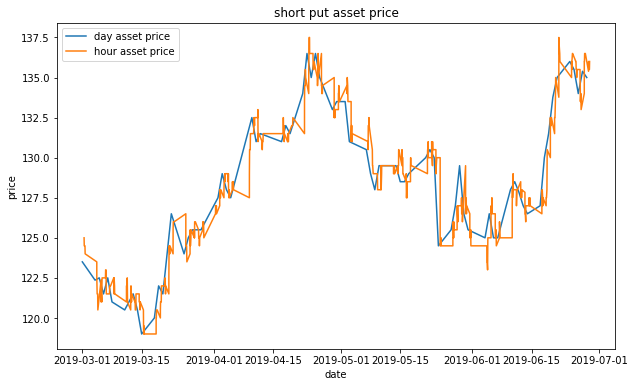

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_sp.index.tolist(), df_sp["asset_price"], label="day asset price")
plt.plot(df_sp2.index.tolist(), df_sp2["asset price"], label="hour asset price")

plt.title('short put asset price')
plt.xlabel("date")
plt.ylabel("price")

plt.legend()

plt.show()

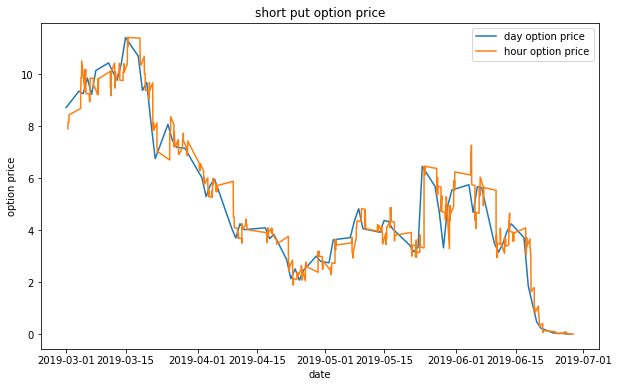

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp.index.tolist(), df_sp["option price"], label="day option price")
plt.plot(df_sp2.index.tolist(), df_sp2["option price"], label="hour option price")

plt.title('short put option price')
plt.xlabel("date")
plt.ylabel("option price")

plt.legend()

plt.show()

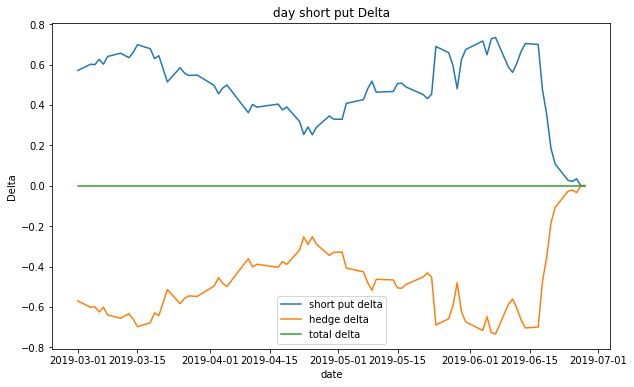

In [42]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp.index.tolist(), df_sp["short put delta"], label="short put delta")
plt.plot(df_sp.index.tolist(), df_sp["hedge delta"], label="hedge delta")
plt.plot(df_sp.index.tolist(), df_sp["short put delta"]+df_sp["hedge delta"], label="total delta")

plt.title('day short put Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

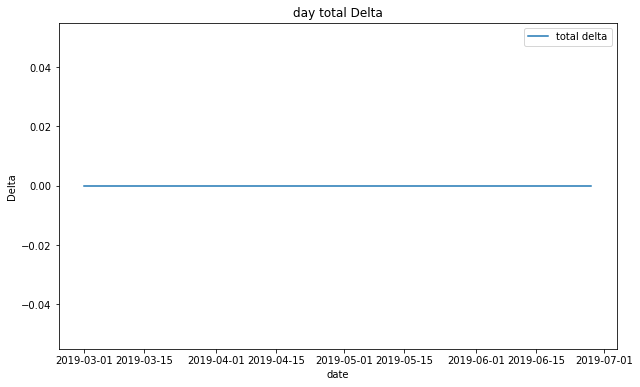

In [43]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp.index.tolist(), df_sp["short put delta"]+df_sp["hedge delta"], label="total delta")

plt.title('day total Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

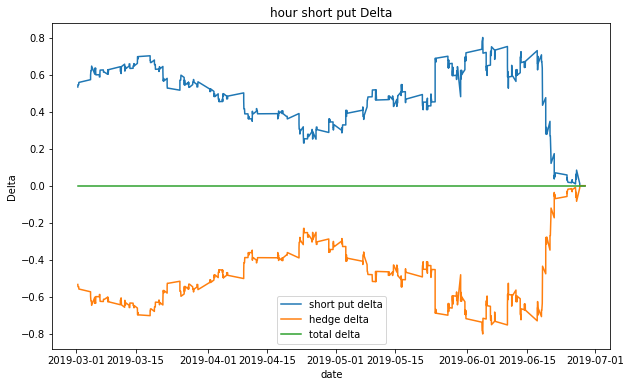

In [44]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp2.index.tolist(), df_sp2["short put delta"], label="short put delta")
plt.plot(df_sp2.index.tolist(), df_sp2["hedge delta"], label="hedge delta")
plt.plot(df_sp2.index.tolist(), df_sp2["short put delta"]+df_sp2["hedge delta"], label="total delta")

plt.title('hour short put Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

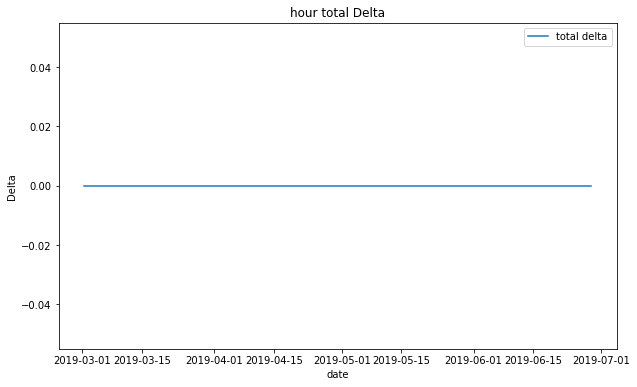

In [45]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp2.index.tolist(), df_sp2["short put delta"]+df_sp2["hedge delta"], label="total delta")

plt.title('hour total Delta')
plt.xlabel("date")
plt.ylabel("Delta")

plt.legend()

plt.show()

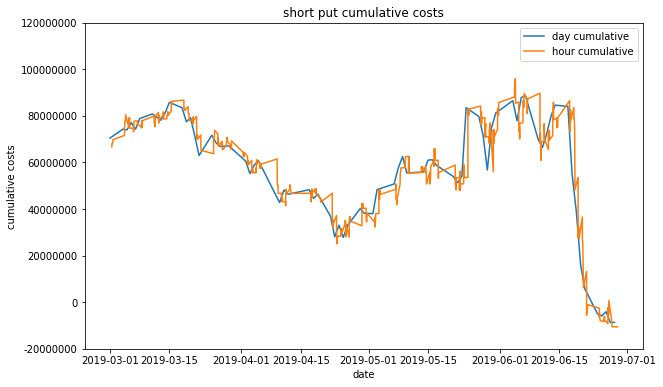

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp.index.tolist(), df_sp["cumulative costs"], label="day cumulative")
plt.plot(df_sp2.index.tolist(), df_sp2["cumulative costs"], label="hour cumulative")

plt.title('short put cumulative costs')
plt.xlabel("date")
plt.ylabel("cumulative costs")

plt.legend()

yy, locs = plt.yticks()
ll = ['%.0f' % a for a in yy]
plt.yticks(yy, ll)

plt.show()

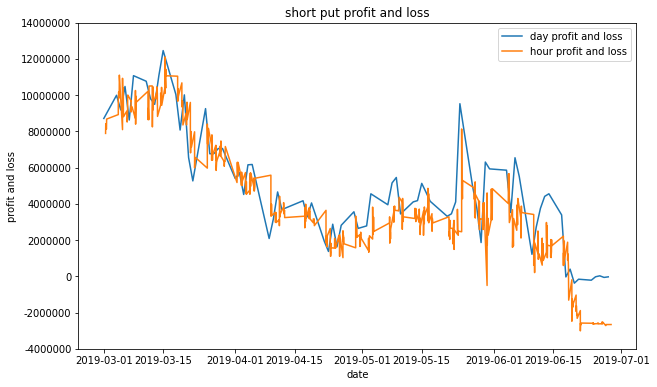

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(df_sp.index.tolist(), df_sp["profit and loss"], label="day profit and loss")
plt.plot(df_sp2.index.tolist(), df_sp2["profit and loss"], label="hour profit and loss")

plt.title('short put profit and loss')
plt.xlabel("date")
plt.ylabel("profit and loss")

plt.legend()

yy, locs = plt.yticks()
ll = ['%.0f' % a for a in yy]
plt.yticks(yy, ll)

plt.show()